In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile('Bergomi1FactorTrainSet.txt.gz', "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
print(xx.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(40000, 4)


In [2]:
def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X) Data ,
    
    X^T * X = CovX = U *d* U^T where the columns of E are the normalized eigenvectors
    D=d^(-1/2), the whitening matrix is W = E * D * E^T: Xw = X*W
    Cov Xw = Xw^T*Xw = E*D*E^T*X^T*X*E*D*E^T = E*D*E^T*CovX*E*D*E^T = E*D*E^T*E *d* E^T*E*D*E^T = I
    The inverse is W^-1: W^-1 = E * D^(-1) * E^T
    The un-whitened matrix is X = (X*W)*W^-1

    Input:
    -X (numpy array): input data, rows are data points, columns are features
    
    Output:
    -X_mean (array): mean of X
    -W (matrix): dewhitening matrix
    """

    EPS = 10e-18
    upperBound=10e14
    meanX = np.mean(X, axis=0)
    Xc = X - meanX

    cov = np.dot(Xc.T, X)/float(Xc.shape[0]-1.0)

    U,d, _ = np.linalg.svd(cov)
    d = np.sqrt(np.clip(a=d, a_min=EPS, a_max=upperBound))
    D_whiten = np.diag(1. / d)
    D_dewhiten = np.diag(d)    
    W = np.dot(np.dot(U, D_whiten), U.T)
    W_dewhiten = np.dot(np.dot(U, D_dewhiten), U.T)
    X_white = np.dot(Xc, W)

    # test
    test1 = np.std(X_white, axis=0)
    test2 = np.add(np.dot(X_white, W_dewhiten),meanX)
    print("white reconstruction error: "+str(np.max( X-test2 )))
    print("white standardization error: " + str(np.max(test1 - np.ones(test1.shape))))
    
    return meanX, W

In [3]:
# Prepare storage for volatilities (IV surfaces) and model parameters
volatilities = {}
parameter = {}

# Use yy as volatilities (Implied Volatility Surfaces)
volatilities['train'] = pd.DataFrame(yy[:int(0.8 * len(yy))])  # 80% train
volatilities['test'] = pd.DataFrame(yy[int(0.8 * len(yy)):])  # 20% test

# Use xx as model parameters (Rough Bergomi Parameters)
parameter['train'] = pd.DataFrame(xx[:int(0.8 * len(xx))])  
parameter['test'] = pd.DataFrame(xx[int(0.8 * len(xx)):])    
X_mean, W = zca_whiten(yy[:int(0.8 * len(yy))])
volatilities_white = {
    'train': pd.DataFrame(np.dot(volatilities['train'].values - X_mean, W)),
    'test': pd.DataFrame(np.dot(volatilities['test'].values - X_mean, W))
}

white reconstruction error: 9.458545058294021e-13
white standardization error: -1.392025942714703e-05


In [4]:
import keras
from keras.layers import Input, Dense
from keras.models import Model

#  Recreate Model Architecture
input1 = Input(shape=(4,))
x1 = Dense(30, activation="elu")(input1)
x2 = Dense(30, activation="elu")(x1)
x3 = Dense(30, activation="elu")(x2)
x4 = Dense(88, activation="linear")(x3)

modelGEN = Model(inputs=input1, outputs=x4)
modelGEN.summary()

#  Load the Weights (This will now work)
modelGEN.load_weights("1FBergomiNN.weights.h5")
print(" Weights loaded successfully!")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,738 (18.51 KB)

 Trainable params: 4,738 (18.51 KB)

 Non-trainable params: 0 (0.00 B)

✅ Weights loaded successfully!


In [5]:
ub=np.array([0.16,4,10,0])
lb=np.array([0.01,0.5,0,-1])
def myscale_0_1(x):
    x = np.array(x)  # Ensure input is a NumPy array
    res = (x - lb) / (ub - lb)  # Element-wise scaling for all rows
    return res
def myinverse_0_1(x):
    x=np.array(x)
    for i in range(4):
        res=x*(ub - lb)+lb
        
    return res

In [6]:
import torch
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
from pyro.infer import MCMC, NUTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  Convert data to tensors
X_train_tensor = torch.tensor(volatilities_white['train'].values, dtype=torch.float32)
y_train_tensor = torch.tensor(parameter['train'].values, dtype=torch.float32)

#  Define Bayesian Model
def model(X, y=None):
    # Prior distributions for Rough Bergomi parameters
    H = pyro.sample("H", dist.Beta(2, 5))  # Hurst exponent
    eta = pyro.sample("eta", dist.Normal(2.0, 1.0))  # Volatility of volatility
    v0 = pyro.sample("v0", dist.Normal(4.0, 1.5))  # Initial variance
    rho = pyro.sample("rho", dist.Normal(-.5, .2))  # Correlation

    # Construct theta as a tensor
    theta = pyro.sample("theta", dist.Normal(torch.zeros(88, 4), torch.ones(88, 4)))  # Correct shape

    # Define likelihood function (Gaussian)
    sigma = pyro.sample("sigma", dist.HalfNormal(1.0))  # Observation noise
    mean_prediction = torch.matmul(X, theta)  # Linear mapping (or use NN for non-linear)
    
    # Likelihood function (observed data)
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Normal(mean_prediction, sigma).to_event(1), obs=y)

In [8]:
# Define the MCMC sampler
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, warmup_steps=500)

# Run MCMC
mcmc.run(X_train_tensor, y_train_tensor)

# Get posterior samples
posterior_samples = mcmc.get_samples()

Warmup:   0%|          | 0/10500 [00:00, ?it/s]

Sample: 100%|██████████| 10500/10500 [04:41, 37.25it/s, step size=2.93e-01, acc. prob=0.863]


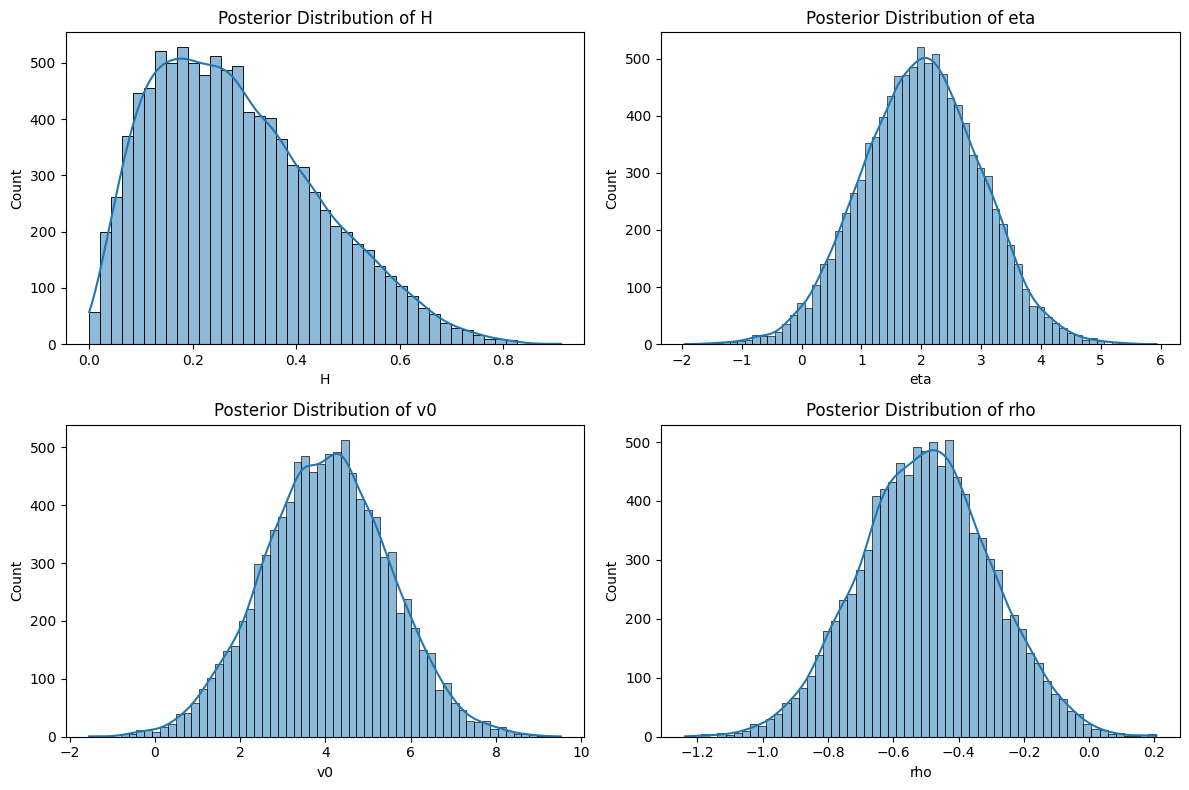

In [9]:
import seaborn as sns

# Convert to DataFrame for visualization
posterior_df = pd.DataFrame({
    "H": posterior_samples["H"].numpy(),
    "eta": posterior_samples["eta"].numpy(),
    "v0": posterior_samples["v0"].numpy(),
    "rho": posterior_samples["rho"].numpy(),
})

# Plot histograms for parameter distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
params = ["H", "eta", "v0", "rho"]

for i, ax in enumerate(axes.flatten()):
    sns.histplot(posterior_df[params[i]], kde=True, ax=ax)
    ax.set_title(f"Posterior Distribution of {params[i]}")

plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import pandas as pd
mcmc_train_time=4*60+42.4

# Load MCMC posterior samples (if not already in `posterior_df`)
posterior_df = pd.DataFrame({
    "H": posterior_samples["H"].numpy(),
    "eta": posterior_samples["eta"].numpy(),
    "v0": posterior_samples["v0"].numpy(),
    "rho": posterior_samples["rho"].numpy(),
})

# Compute MCMC Posterior Mean & Std
mcmc_posterior_mean = posterior_df.mean().to_numpy()
mcmc_posterior_std = posterior_df.std().to_numpy()

# Save Results
np.save("mcmc_mean.npy", mcmc_posterior_mean)
np.save("mcmc_std.npy", mcmc_posterior_std)
np.save("mcmc_time.npy", mcmc_train_time)  # Replace `mcmc_train_time` with actual recorded time

print("✅ MCMC results saved!")

✅ MCMC results saved!


In [11]:
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)

X_train_tensor shape: torch.Size([32000, 88])
y_train_tensor shape: torch.Size([32000, 4])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


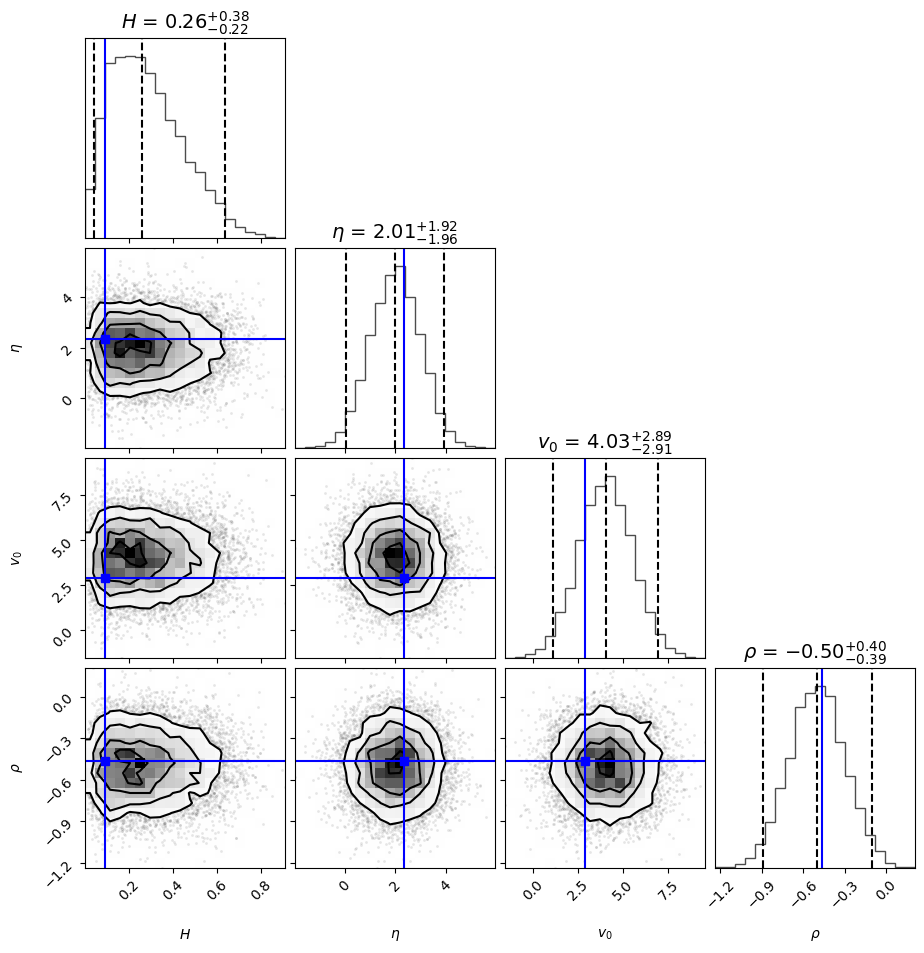

In [13]:
import numpy as np
import corner
import matplotlib.pyplot as plt

# Compute median or select specific sample
true_params = np.median(xx, axis=0)  # Change as needed

# Labels for parameters
param_labels = [r"$H$", r"$\eta$", r"$v_0$", r"$\rho$"]

# Generate the corner plot with true values
fig = corner.corner(
    posterior_df.values,  # MCMC posterior samples
    labels=param_labels,
    truths=true_params,  # Add true values (median, single sample, etc.)
    truth_color="blue",  # Color for true values
    quantiles=[0.025, 0.5, 0.975],  # Show credible intervals
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 14},
    hist_kwargs={"density": True, "alpha": 0.7}  # Adjust histogram transparency
)
plt.savefig("BayesianMCMC.eps",format="eps",dpi=300)
plt.show()


In [35]:
true_parameter=np.median(xx,axis=0)

In [34]:
true_parameter

array([ 0.0575803,  2.53648  ,  3.38008  , -0.0976816])